In [1]:
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
from scipy.spatial import distance
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.sparse.csgraph import shortest_path
import scipy.sparse.linalg as ll
%matplotlib inline
import util
import sys

In [2]:
### GET DATA

datamap, image_arr = util.get_compressed_data(compression=(25,25), debug=True)

Total Time: 101.64017367362976
Initial SetUp Time: 31.496638774871826
Datamap Time (A): 70.08059000968933
Image Arr Time (B): 0.06294488906860352


(33630, 626)


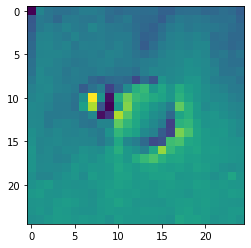

In [3]:
image_arr
print(image_arr.shape)
util.show_image(image_arr[9][:-1].reshape(25, 25))


# To view without label: image_arr[:,1:]

In [4]:
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
(sorted([(x, sys.getsizeof(globals().get(x))/1000000000) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True))

[('image_arr', 0.16841916),
 ('datamap', 0.072502704),
 ('AnnotationBbox', 1.064e-06),
 ('OffsetImage', 1.064e-06),
 ('distance', 7.2e-08),
 ('ll', 7.2e-08),
 ('np', 7.2e-08),
 ('plt', 7.2e-08),
 ('shortest_path', 7.2e-08),
 ('spio', 7.2e-08)]

In [5]:
image_arr.dtype

dtype('int64')

In [6]:
sys.getsizeof(image_arr)
# 33630*51530
13863631320 / (33630*51530)
print("Before", sys.getsizeof(image_arr), image_arr.dtype)

image_arr = image_arr.astype(np.int32)
# image_arr = image_arr.astype(np.float64)
# print("After:", sys.getsizeof(image_arr), image_arr.dtype)


Before 168419160 int64


In [7]:
# image_arr[:,1:] *= (255/image_arr[:,1:].max())
image_arr

array([[    7, 15780, 15019, ...,     0,     0,     0],
       [    7, 15167, 15407, ..., 15099, 15038, 15122],
       [    7, 17827, 17344, ...,     0,     0,     0],
       ...,
       [    0,  9286,  9922, ...,  9346,  9525,  9148],
       [    0,  9600, 11770, ...,  9258,  8794,  8979],
       [    0,     3,  1539, ...,  9733, 10143,  9672]])

In [8]:
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
(sorted([(x, sys.getsizeof(globals().get(x))/1000000000) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True))

[('image_arr', 0.08420964),
 ('datamap', 0.072502704),
 ('AnnotationBbox', 1.064e-06),
 ('OffsetImage', 1.064e-06),
 ('distance', 7.2e-08),
 ('ll', 7.2e-08),
 ('np', 7.2e-08),
 ('plt', 7.2e-08),
 ('shortest_path', 7.2e-08),
 ('spio', 7.2e-08)]

(33630, 626)


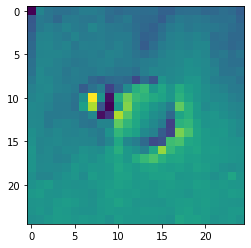

In [9]:
image_arr.shape

image_arr
print(image_arr.shape)
util.show_image(image_arr[9][:-1].reshape(25, 25))

In [10]:
image_arr_trans = image_arr.copy().T
image_arr_trans

array([[    7,     7,     7, ...,     0,     0,     0],
       [15780, 15167, 17827, ...,  9286,  9600,     3],
       [15019, 15407, 17344, ...,  9922, 11770,  1539],
       ...,
       [    0, 15099,     0, ...,  9346,  9258,  9733],
       [    0, 15038,     0, ...,  9525,  8794, 10143],
       [    0, 15122,     0, ...,  9148,  8979,  9672]])

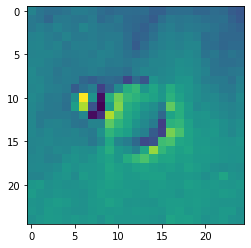

In [11]:
image_arr_trans.shape
util.show_image(image_arr_trans[1:][:,9].reshape(25,25))

In [12]:
image_arr_trans.max()

20642

Starting


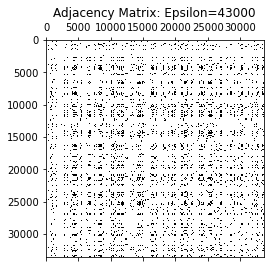

In [13]:
#####
# A #
#####

def get_adjacency(data, epsilon=12, distance_type="euclidean", plot_graph=True, debug=False, save=True):
    print("Starting")
    adj = distance.cdist(data.T, data.T, distance_type)

    if debug:
        print("SHAPE:", adj.shape)

    adj[adj > epsilon] = 0

    if plot_graph:
        fig, ax1 = plt.subplots()

        plt.title(f"Adjacency Matrix: Epsilon={epsilon}")
        ax1.spy(adj)

        plt.show()
        
        if save:
            fig.savefig(f'Q3_adj_matrix_{epsilon}-epsilon.png', dpi=2400)

    return adj

# Visualize the nearest neighbor graph (show the adjacency matrix)
# illustrate a few images corresponds to nodes at different parts of the graph

epsilon = 100 # smaller epsilons seem to work better, using 50 and 20 as examples for assignment
adj_demo = get_adjacency(image_arr_trans[1:], epsilon=43000)
# del adj_demo
# adj_demo = get_adjacency(image_arr_trans[1:], epsilon=2500)
# del adj_demo

# # Get the adjacency matrix
# adj_demo = get_adjacency(image_arr_trans[1:], epsilon=5000)

In [15]:
def isomap(adj, debug=False):
    D = shortest_path(adj, directed=False)

    # Use Centering Matrix
    m, n = D.shape

    H = np.identity(m) - 1/m * np.ones((m,m))
    C = -1/2 * H.dot(np.square(D)).dot(H)

    if debug:
        print("C SHAPE:", C.shape)

    # Compute eigendecomposition of C
    # https://stackoverflow.com/questions/8092920/sort-eigenvalues-and-associated-eigenvectors-after-using-numpy-linalg-eig-in-pyt
    K = 2
    eigenvalues, eigenvectors = ll.eigs(C)

    idx = eigenvalues.argsort()[::-1]
    # print(idx)
    eigenvalues = eigenvalues[idx]
    eigenvalues = eigenvalues[:K]
    eigenvectors = eigenvectors[:, idx]
    eigenvectors = eigenvectors[:, :K]

    if debug:
        print("eigenvalues:", eigenvalues)
        print("eigenvectors:", eigenvectors)

    eigenvalues_sqrt = np.sqrt(eigenvalues)

    Z = (eigenvectors.dot(np.diag(eigenvalues_sqrt))).real

    if debug:
        print("Z:", Z.shape)
        print(Z)

    return Z

In [ ]:
#####
# B #
#####

# Implement the ISOMAP algorithm yourself to obtain a 2d embedding
# Plot the embeddings using a scatter plot, similar to the plots in lecture slides
# adj = get_adjacency(image_arr[:,1:], epsilon=43000, plot_graph=False)
Z = isomap(adj_demo)



In [83]:
def plot_isomap(Z, data, num_faces=25, show_faces=True, save=True, save_name="default.png"):
    # Set up size of graph
    fig = plt.figure()
    fig.set_size_inches(18.5, 10)
    ax = fig.add_subplot()

    if show_faces:
        for i in range(num_faces):
            # select an face
            face_num = np.random.randint(0,Z.shape[0])

            # Get the face
            face = data[face_num].reshape(25, 25).T
            face_x, face_y = Z[:, 0][face_num], Z[:, 1][face_num]  # location
            imagebox = OffsetImage(face, zoom=1, cmap="Greys")

            ab = AnnotationBbox(imagebox, [face_x, face_y],
                                xybox=(30., -30.),
                                xycoords='data',
                                boxcoords='offset points')
            ax.add_artist(ab)

    ax.scatter(Z[:, 0], Z[:, 1])
    ax.set_title("ISOMAP FACE ORIENTATIONS")

    ax.set_ylabel('Up-Down Pose')
    ax.set_xlabel('Left-right Pose')

    if save:
        plt.savefig(save_name)
    return None


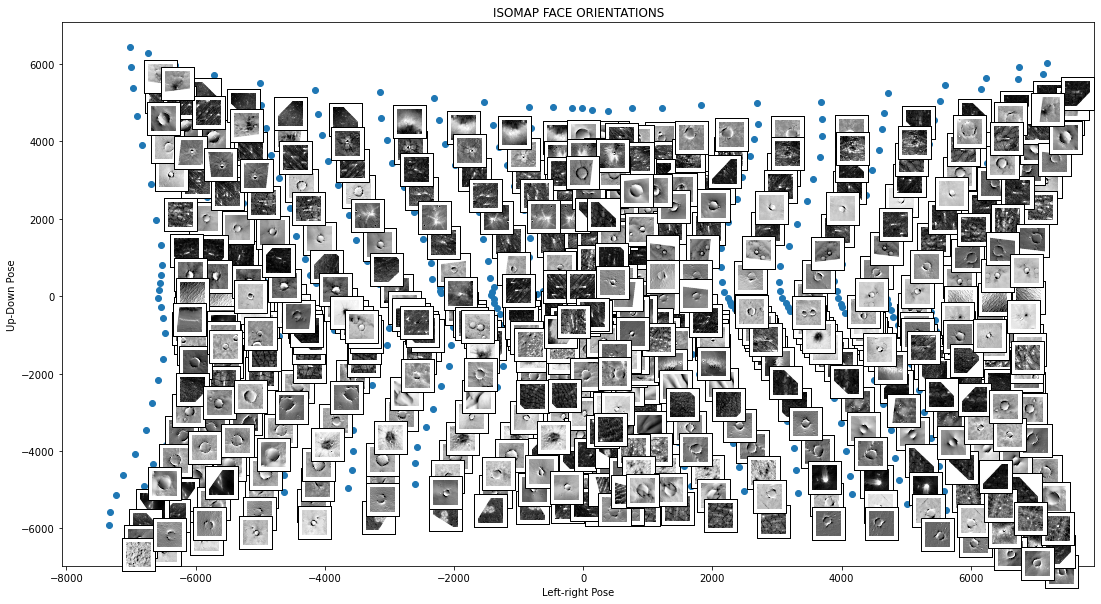

In [84]:
plot_isomap(Z, image_arr[:,1:], 10000,True, False, "Q3_ISOMAP.png")

In [67]:
 image_arr[:,1:][:, 9].reshape(25, 25)

ValueError: cannot reshape array of size 33630 into shape (25,25)

In [82]:
np.random.randint(0,Z.shape[0])

325

In [87]:
image_arr.T.shape

(626, 33630)

In [86]:
Z.shape

(625, 2)